# Advanced simulations of a 2D Ising model

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import re
import matplotlib.animation as animation
import matplotlib.patheffects as pe
import os
from io import StringIO
from IPython.display import HTML
import csv


## Some visualisations

In [2]:
filepath = "./data/cluster_size_statistics/" 
filename = "L=50_T=1.134593_N=10000.csv"

In [18]:
with open("./data/cluster_size_statistics/L=50_T=1.134593_N=10000_cluster_sizes.csv") as f:
    configurations = f.read().split("\n\n")

lattices = []
temp_matrices = []
for matrices in configurations:
    temp_matrice = matrices.split("\n")
    for i in range(len(temp_matrice)):
        try:
            temp_matrice[i] =  list(map(int,temp_matrice[i].split(',')))
        except(ValueError): #Nice to have since some blanksoaces fucks up the code
            print(temp_matrice[i])
            print(i)

    lattices.append(temp_matrice)


In [5]:
filepath = "./data/cluster_size_statistics/" 
filename_25_Tl = "L=25_T=1.134593_N=10000.csv"
filename_25_Tc = "L=25_T=2.269185_N=10000.csv"
filename_50_Tl = "L50_T=1.134593_N=10000.csv"

In [6]:

def file_to_data(filepath, filename):
    with open(filepath + filename) as f:
        configurations = f.read().split("\n\n")

    lattices = []
    #Ignoring last whitespace element
    for matrices in configurations[:-1]:
        temp_matrice = matrices.split("\n")
        for i in range(len(temp_matrice)):
            try:
                temp_matrice[i] =  list(map(int,temp_matrice[i].split(',')))
            except(ValueError): #Nice to have since some blanksoaces fucks up the code
                # print(temp_matrice[i])
                print(i)
                pass

        lattices.append(temp_matrice)
    print("len conf. data:", len(configurations))
    print("len lattices ", len(lattices))
    print("len lattice element: ", len(lattices[0]))
    return lattices

### Cluster size statistics

In [7]:
#Filepaths
L=50
sweeps = 10000
Ts = [1.134593, 2.269185, 4.538371]
path = "./data/cluster_size_statistics/"
import pandas as pd

In [8]:
def csv_reader(filename):
    # data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            data = row
    return np.asarray(data, float)

def txt_reader(filename):
    with open(filename, 'r') as f:
        data = [float(line.strip()) for line in f]
    return np.array(data)

Total sweeps:  10000


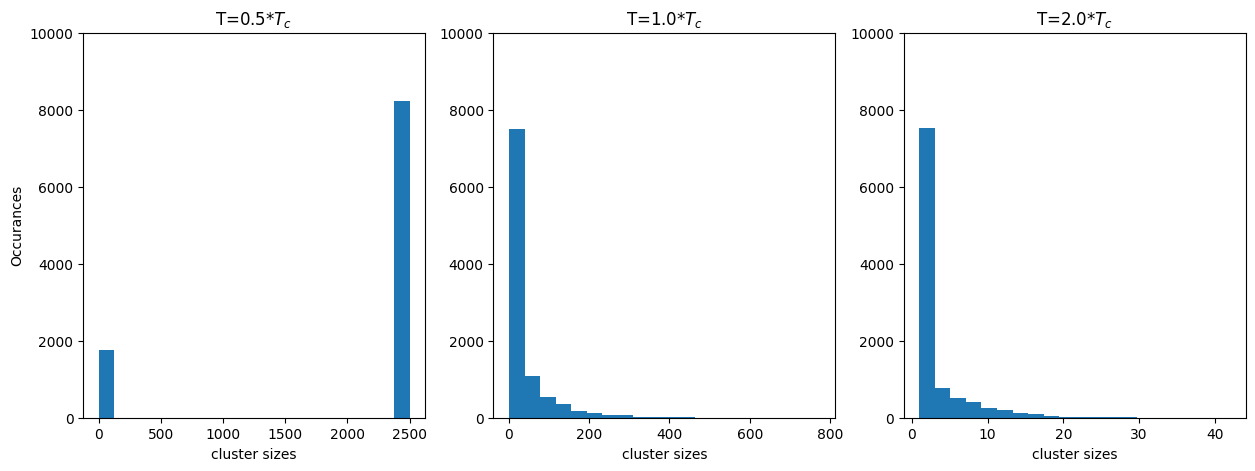

In [9]:
fig, axes = plt.subplots(1,len(Ts))
print("Total sweeps: ", sweeps)
for i in range(len(Ts)):
    filename = path + "L="+str(L)+"_T="+str(Ts[i])+"_N="+str(sweeps)+"_cluster_sizes.csv"
    if os.path.exists(filename):
        data = csv_reader(filename)
    else:
        print("Didn't find file: ", filename)
    
    nbins = 20
    axes[i].hist(data, bins=nbins)
    axes[i].set_title("T="+str(round(Ts[i]/Ts[1],1))+r"*$T_c$")
    axes[i].set_xlabel("cluster sizes")
    axes[i].set_ylim(0,sweeps)
axes[0].set_ylabel("Occurances")


# fig.suptitle(f"L = {L}", size=20)
fig.set_size_inches(15,5)
plt.show()


One can note that for temperatures below the critical point, one could flip the whole grid in one sweep. This could be due to little thermal fluctuations, allowing the flip to easiliy happen.
For temperatures around $T_c$ and above, this would not happen since the tempearture won't allow the cluster to grow to large, statistically speaking, since the probability of flipping a spin goes towards 0, as $\beta$ goes towards 0.

## Autocorrelation time

In [20]:
from scipy.optimize import curve_fit

def autocorrelation_time(filepath, filename_E, filename_M, L, t, ax, csv=True):
    match(L):
        case 25:
            t_eq = 2000
        case 50:
            t_eq = 4500
        case 100:
            t_eq = 2000
        case _ :
            t_eq = 5000

    if csv:
        energies =  csv_reader(filepath + filename_E)[t_eq:]
        magnetizations =  csv_reader(filepath + filename_M)[t_eq:] #Cutting of data after equilibrium
    else:
        energies =  txt_reader(filepath + filename_E)[t_eq:]
        magnetizations =  txt_reader(filepath + filename_M)[t_eq:]
    #Averages over each spin
    energies /= L**2
    magnetizations /= L**2

    def Co(t, O):
        Co_first = 0
        Co_second = 0
        Co_third = 0
        t_max = len(O)
        div_fac = 1/(t_max - t)
        for t_it in range(t_max-t):
            Co_first += O[t_it] * O[t_it + t] * div_fac
            Co_second += O[t_it] * div_fac
            Co_third += O[t_it + t] * div_fac

        return Co_first - Co_second*Co_third


    Cm_t = [Co(t_it, magnetizations) for t_it in range(t)]
    Ce_t = [Co(t_it, energies) for t_it in range(t)]
    ts = np.linspace(0,t, dtype=int, num=len(Cm_t))
    print(f"Magnetic Co: {Co(t, magnetizations)}")
    print(f"Energy Co: {Co(t, energies)}")
    print(f"len mag: {len(magnetizations)}, len cm_t: {len(Cm_t)}, len ts: {len(ts)}")    
    
    #Plotting and fitting section
    f = lambda t,tau,a,b: a + b*np.e**(-t/tau) 
    popt_mag, pcov_mag = curve_fit(f, ts, Cm_t )
    popt_en, pcov_en = curve_fit(f, ts, Ce_t)

    perr_mag = np.sqrt(np.diag(pcov_mag))
    perr_en = np.sqrt(np.diag(pcov_en))
    print(f"Tau for magnetization = {popt_mag[0]} ± {perr_mag[0]}")
    print(f"Tau for energy = {popt_en[0]} ± {perr_en[0]}")

    #---------Magnetization------------
    ax.plot(ts, Cm_t, label=r"$C_m(t)$")
    ax.plot(ts, f(ts, *popt_mag), label=r"$\tau_m$ fitted %3.3f ± %3.3f" % (popt_mag[0], perr_mag[0]))
    ax.set_xlabel("time (MC steps per spin)")
    ax.legend()
    #---------Energy-------------
    ax.plot(ts, Ce_t, label=r"$C_e(t)$")
    ax.plot(ts, f(ts, *popt_en), label=r"$\tau_e$ fitted = %3.3f ± %3.3f" % (popt_en[0], perr_en[0]))
    ax.set_xlabel("time (MC steps per spin)")
    ax.legend()

    return popt_en[0], popt_mag[0]


### Test autocorrelation for 10 Ls

Magnetic Co: -0.011888281203985773
Energy Co: -0.010545308448294932
len mag: 5001, len cm_t: 500, len ts: 500
Tau for magnetization = 0.5990062490783195 ± 0.02744305881695747
Tau for energy = 3.658941337137306 ± 0.13764820031936165
[(3.658941337137306, 0.5990062490783195)]
Magnetic Co: 0.001831746582678817
Energy Co: 0.0015570854654081145
len mag: 5001, len cm_t: 500, len ts: 500
Tau for magnetization = 2.0066748151864515 ± 0.06960069092223589
Tau for energy = 11.362001754016688 ± 0.4304989563743336
[(3.658941337137306, 0.5990062490783195), (11.362001754016688, 2.0066748151864515)]
Magnetic Co: -0.0005102905791358747
Energy Co: 0.0021270425874089227
len mag: 5001, len cm_t: 500, len ts: 500
Tau for magnetization = 4.256583305612842 ± 0.1537401806843729
Tau for energy = 21.97840573585344 ± 0.5004674621195006
[(3.658941337137306, 0.5990062490783195), (11.362001754016688, 2.0066748151864515), (21.97840573585344, 4.256583305612842)]
Magnetic Co: -0.002384308225591214
Energy Co: 0.000656720

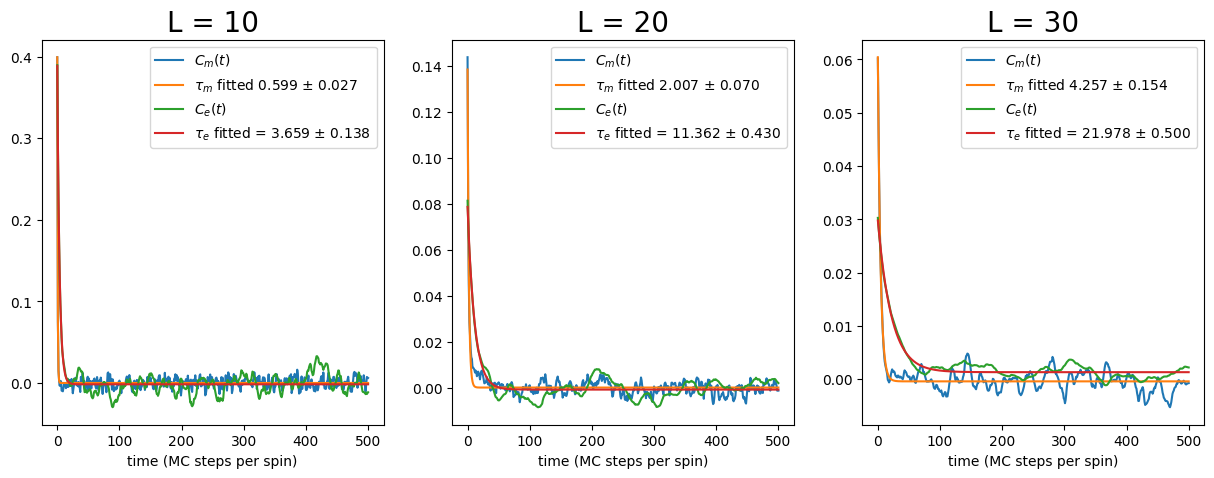

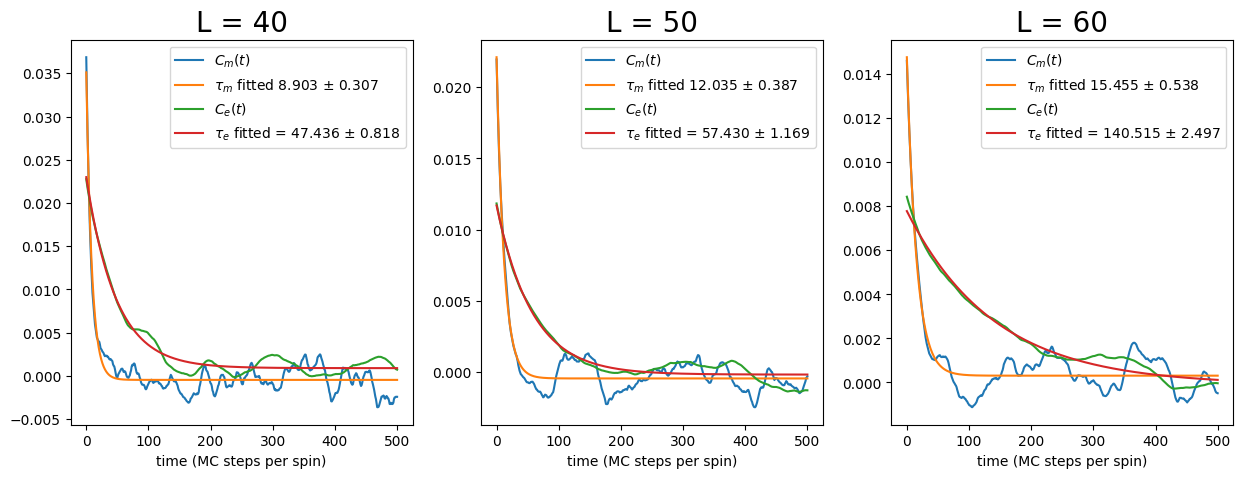

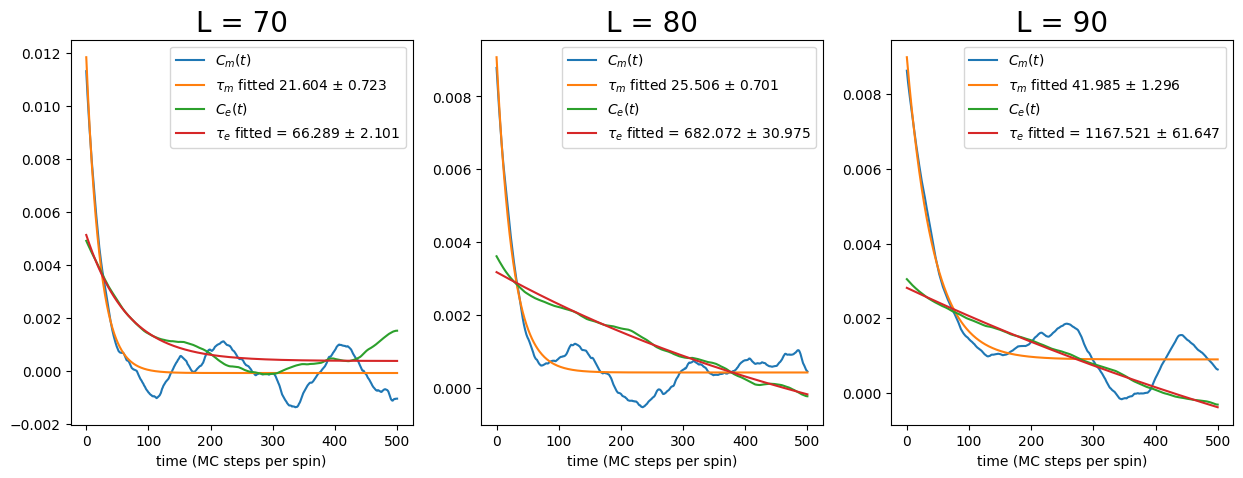

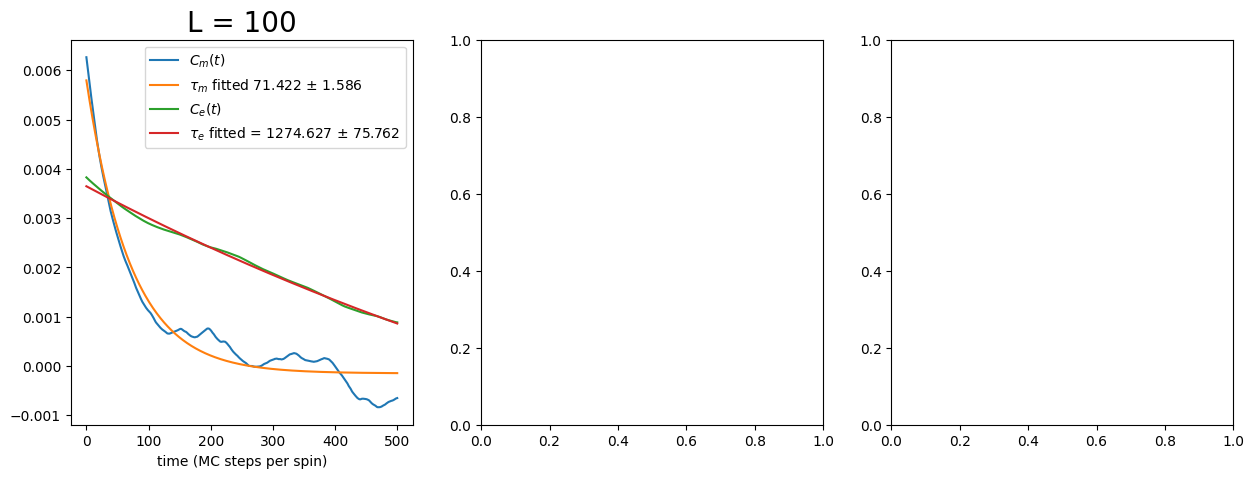

In [34]:
many_Ls = np.linspace(10,100,num=10, dtype=int)
T = 2.269185
filepath = "./data/many_observables/"
taus_W2 = []
for i in range(len(many_Ls)):
    if i%3 == 0:
        fig, axes = plt.subplots(1,3)
    filename_E = "L="+str(many_Ls[i])+"_T="+str(T)+"_N="+str(sweeps)+"_energies.csv"
    filename_M = "L="+str(many_Ls[i])+"_T="+str(T)+"_N="+str(sweeps)+"_magnetizations.csv"
    taus_W2.append(autocorrelation_time(filepath, filename_E, filename_M, many_Ls[i], 500, axes[i%3], True))
    print(taus_W2)
    axes[i%3].set_title(f"L = {many_Ls[i]}", size=20)
    fig.set_size_inches(15,5)
plt.show()

#### SS Model

Magnetic Co: 0.19157500033580188
Energy Co: -0.0026324669629675945
len mag: 5000, len cm_t: 500, len ts: 500
Tau for magnetization = 511.8909886381594 ± 12.058897293520753
Tau for energy = 8.201270010904778 ± 0.4112539897640122
Magnetic Co: 0.3211348130567903
Energy Co: 0.0001479733728482202
len mag: 5000, len cm_t: 500, len ts: 500
Tau for magnetization = 5320488.779080367 ± 96491626.79200536
Tau for energy = 81.27900287027272 ± 3.1298874971323283
Magnetic Co: 0.2677727976040246
Energy Co: -0.0021153619948144353
len mag: 5000, len cm_t: 500, len ts: 500
Tau for magnetization = 402.9126739216667 ± 3.974920395926736
Tau for energy = 126.00319846780177 ± 3.2096786059487554
Magnetic Co: 0.0017993762138892033
Energy Co: 0.00018578952746572952
len mag: 5000, len cm_t: 500, len ts: 500
Tau for magnetization = 119.63595928822544 ± 3.067572717620291
Tau for energy = 71.36728526900555 ± 1.9477136846132401
Magnetic Co: 0.05922474507614872
Energy Co: 0.0003630612809746303
len mag: 5500, len cm_t:

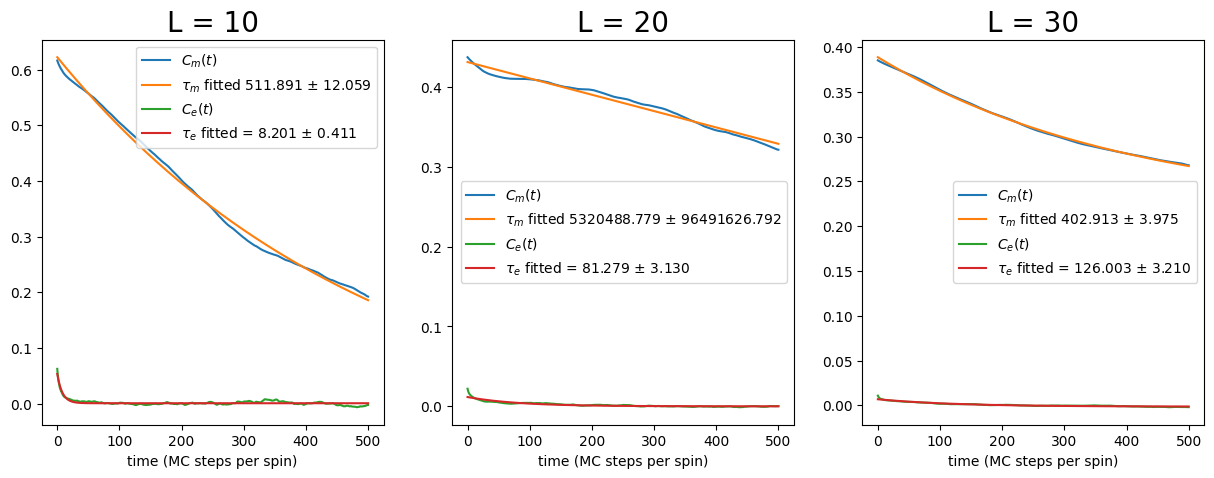

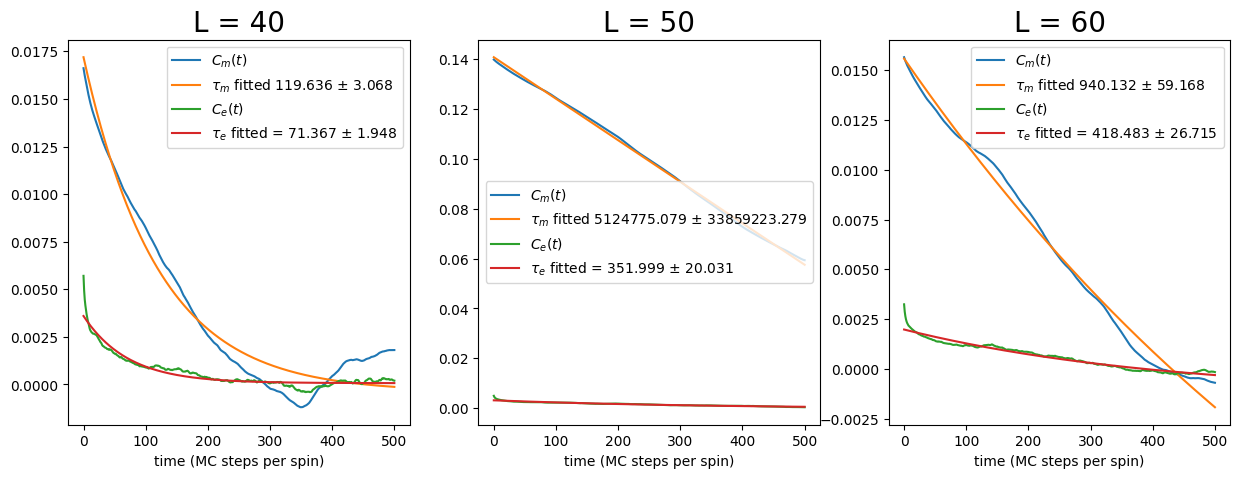

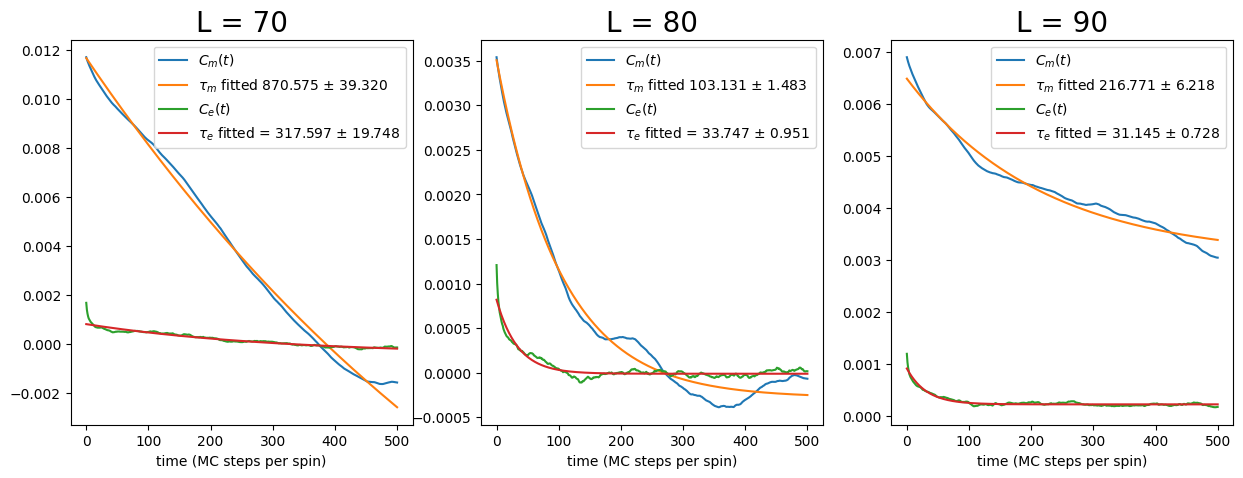

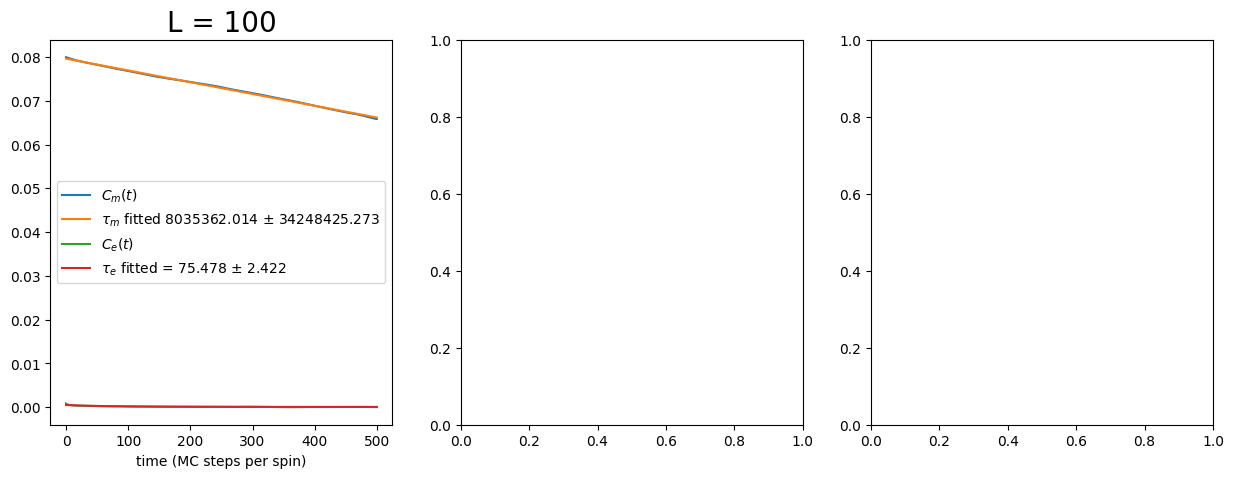

In [35]:

many_Ls_SS = many_Ls
T = 2.269185
sweeps = 10000
filepath_SS = "./data/many_observables_SS/"
taus_W2_SS = []
for i in range(len(many_Ls_SS)):
    if i%3 == 0:
        fig, axes = plt.subplots(1,3)
    filename_E = "energies_L="+str(many_Ls_SS[i])+"_sweeps="+str(sweeps)+".txt"
    filename_M = "magnetizations_L="+str(many_Ls_SS[i])+"_sweeps="+str(sweeps)+".txt"
    taus_W2_SS.append(autocorrelation_time(filepath_SS, filename_E, filename_M, many_Ls_SS[i], 500, axes[i%3], csv=False))
    axes[i%3].set_title(f"L = {many_Ls_SS[i]}", size=20)
    fig.set_size_inches(15,5)
plt.show()

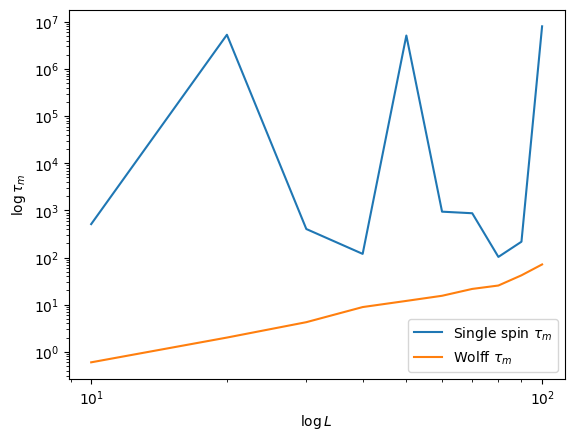

In [37]:
taus_SS_mag_W2 = [mag for en,mag in taus_W2_SS]
taus_W2_mag = [mag for en,mag in taus_W2]
plt.loglog(many_Ls_SS, taus_SS_mag_W2, label=r"Single spin $\tau_m$")
plt.loglog(many_Ls, taus_W2_mag, label=r"Wolff $\tau_m$")
# plt.plot(Ls, taus_W_mag, label=r"Wolff $\tau_m$")
tau_W_theo = lambda a,b,L, zW :a + b*L**zW
tau_W_theos = [tau_W_theo(taus_W2_mag[0], 10, L,0.25) for L in many_Ls]
# plt.loglog(many_Ls, tau_W_theos)
plt.xlabel(r"$\log{L}$")
plt.ylabel(r"$\log{\tau_m}$")
plt.legend()

plt.show()

As expected, the Wolff alogrithm performs better than the single spin alorithm, since the autocorrelation time is smaller, meaning that each step is more independent from the previous ones, which makes it easier to explore new magnetization phases easilier. 

The wolff autocorrelation time doesn't seem to follow the excact path of $L^{zW}$ with $Zw=0.25$, but seems to not be too far of either.

## Multiple Markov chains

In [38]:
filepath_MMC = "./data/MMC/"
filepath_MMC_no_swap = "./data/MMC_no_swap/"
filename_perc_MMC = "percentages_L=25_N=10000.txt"
L_MMC = 25
sweeps_MMC = 10000
Ts_MMC = np.linspace(1,5,num=10)

In [39]:
print("Swapping rates for MMC:")
with open(filepath_MMC + filename_perc_MMC, "r") as f:
    for line in f:
        print(line)
print("Swapping rates for MMC with no intended swaps:")
with open(filepath_MMC_no_swap + filename_perc_MMC, "r") as f:
    for line in f:
        print(line)

Swapping rates for MMC:
Total swap percentage: 0.10959

Swapping rates for MMC with no intended swaps:
Total swap percentage: 0



### Autocorrelation time

In [40]:

def autocorrelation_time_MMC(filename_MMC, filename_MMC_no_swaps, L, t, ax, csv=True):
    match(L):
        case 25:
            t_eq = 2000
        case 50:
            t_eq = 4500
        case 100:
            t_eq = 2000
        case _ :
            t_eq = 5000

    if csv:
        magnetizations_MMC =  csv_reader(filename_MMC)[t_eq:]
        magnetizations_MMC_no_swaps =  csv_reader(filename_MMC_no_swaps)[t_eq:]

    else:
        magnetizations_MMC =  txt_reader(filename_MMC)[t_eq:]
        magnetizations_MMC_no_swaps =  txt_reader(filename_MMC_no_swaps)[t_eq:]
    #Averages over each spin
    magnetizations_MMC /= L**2
    magnetizations_MMC_no_swaps /= L**2

    def Co(t, O):
        Co_first = 0
        Co_second = 0
        Co_third = 0
        t_max = len(O)
        div_fac = 1/(t_max - t)
        for t_it in range(t_max-t):
            Co_first += O[t_it] * O[t_it + t] * div_fac
            Co_second += O[t_it] * div_fac
            Co_third += O[t_it + t] * div_fac

        return Co_first - Co_second*Co_third


    Cm_t_MMC = [Co(t_it, magnetizations_MMC) for t_it in range(t)]
    Cm_t_MMC_no_swaps = [Co(t_it, magnetizations_MMC_no_swaps) for t_it in range(t)]
    ts = np.linspace(0,t, dtype=int, num=len(Cm_t_MMC))
    # print(f"Magnetic MMC Co: {Co(t, magnetizations_MMC)}")
    # print(f"Magnetic MMC no swaps Co: {Co(t, magnetizations_MMC_no_swaps)}")
    # print(f"len mag: {len(magnetizations_MMC)}, len cm_t: {len(Cm_t_MMC)}, len ts: {len(ts)}")    
    
    #Plotting and fitting section
    f = lambda t,tau,a,b: a + b*np.e**(-t/tau) 
    popt_mag_MMC, pcov_mag_MMC = curve_fit(f, ts, Cm_t_MMC )
    popt_mag_MMC_no_swaps, pcov_mag_MMC_no_swaps = curve_fit(f, ts, Cm_t_MMC_no_swaps)

    perr_mag_MMC = np.sqrt(np.diag(pcov_mag_MMC))
    perr_mag_MMC_no_swaps = np.sqrt(np.diag(pcov_mag_MMC_no_swaps))
    # print(f"Tau for magnetization = {popt_mag_MMC[0]} ± {perr_mag_MMC[0]}")
    # print(f"Tau for energy = {popt_mag_MMC_no_swaps[0]} ± {perr_mag_MMC_no_swaps[0]}")

    #---------Magnetization MMC------------
    ax.plot(ts, Cm_t_MMC, label=r"$C_{MMC}(t)$")
    ax.plot(ts, f(ts, *popt_mag_MMC), label=r"$\tau_{MMC}$ fitted %3.3f ± %3.3f" % (popt_mag_MMC[0], perr_mag_MMC[0]))
    ax.set_xlabel("time (MC steps per spin)")
    ax.legend()
    #---------Magnetization MMC no swaps-------------
    ax.plot(ts, Cm_t_MMC_no_swaps, label=r"$C_{no}(t)$")
    ax.plot(ts, f(ts, *popt_mag_MMC_no_swaps), label=r"$\tau_{{{no}}}$ fitted = %3.3f ± %3.3f" % (popt_mag_MMC_no_swaps[0], perr_mag_MMC_no_swaps[0]))
    ax.set_xlabel("time (MC steps per spin)")
    ax.legend()

    return popt_mag_MMC[0], popt_mag_MMC_no_swaps[0]


C:\Users\iver_y\AppData\Local\Temp\ipykernel_17968\80948643.py:45: RuntimeWarning: overflow encountered in power
  f = lambda t,tau,a,b: a + b*np.e**(-t/tau)
c:\Users\iver_y\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


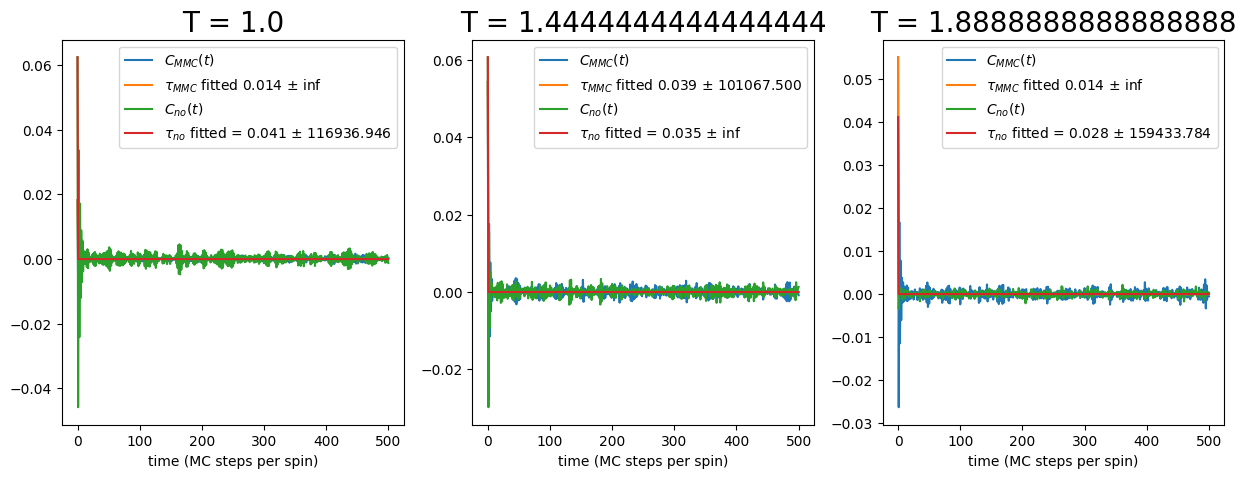

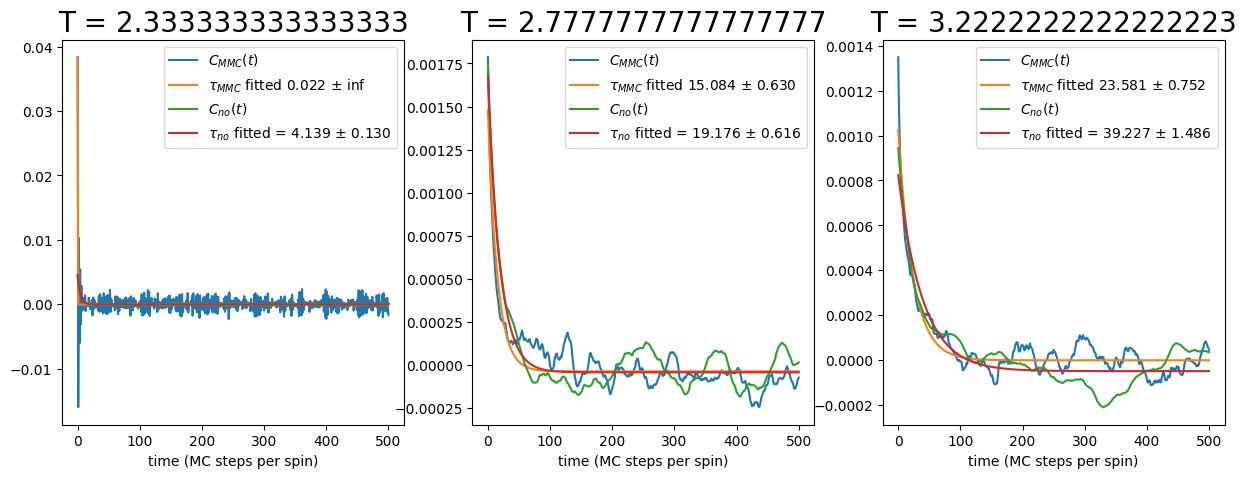

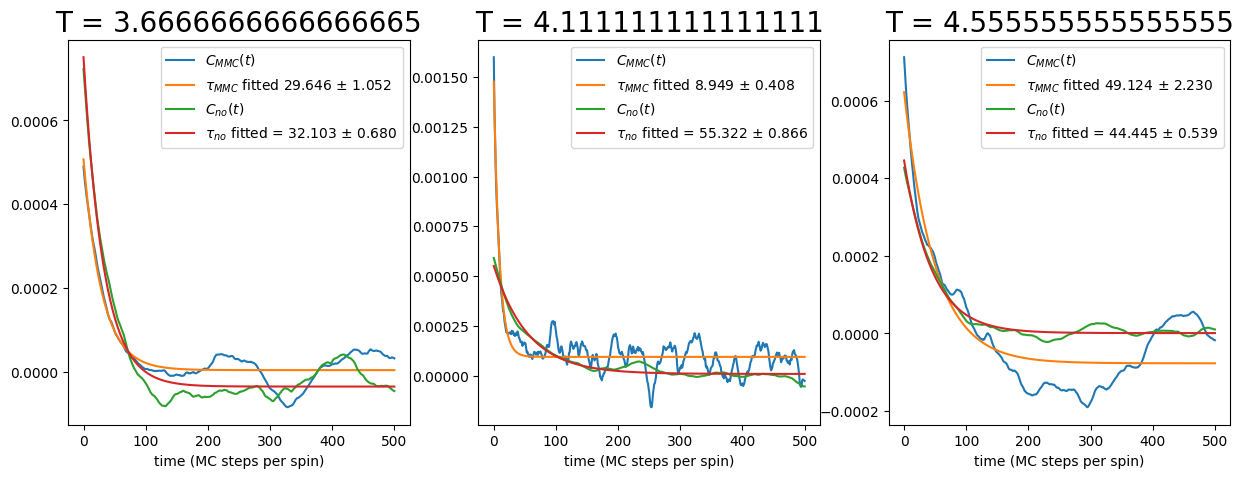

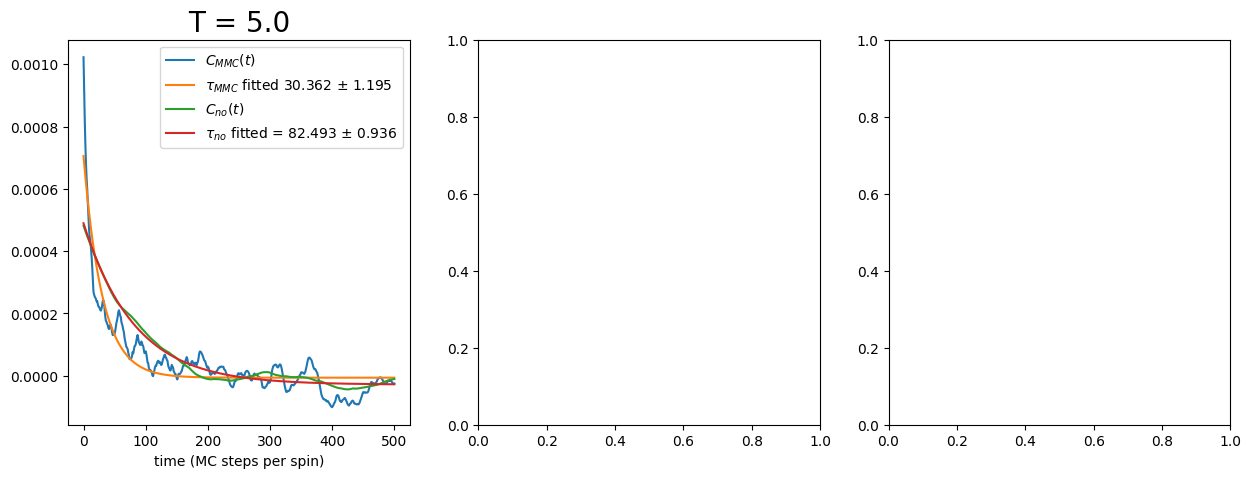

In [41]:
taus_MMC = []
taus_MMC_no_swap = []
for i in range(len(Ts_MMC)):
    if i%3 == 0:
        fig, axes = plt.subplots(1,3)
    filename_MMC = filepath_MMC + "L=25_T={:.6f}_N={}_magnetizations.csv".format(Ts_MMC[i], sweeps_MMC)
    filename_MMC_no_swap = filepath_MMC_no_swap + "L=25_T={:.6f}_N={}_magnetizations.csv".format(Ts_MMC[i], sweeps_MMC)
    #New autocorrelation_time
    tau_MMC, tau_MMC_no_swaps = autocorrelation_time_MMC(filename_MMC, filename_MMC_no_swap, L, 500, axes[i%3], csv=True)
    taus_MMC.append(tau_MMC)
    taus_MMC_no_swap.append(tau_MMC_no_swaps)
    axes[i%3].set_title(f"T = {Ts_MMC[i]}", size=20)
    fig.set_size_inches(15,5)
plt.show()

In 8 out of 10 Markov chains, the MMC performs better, in terms of smaller autocorrelation time. This is a good argument for MMC over single MC implementations.